# MinMod Knowledge Graph

### live at [https://minmod.isi.edu/](https://minmod.isi.edu/) wrapping a [SPARQL Endpoint](https://minmod.isi.edu/sparql).

MinMod is the mineral data **Knowledge Graph (KG)**, integrating heterogeneous data sources including: grade-tonnage data extracted from **mine reports**, **scholarly articles**, **mine site databases**, and **structured tables** to provide a rich, queryable graph of mineral site information, and **links** to additional knowledge bases such as [GeoKB](https://geokb.wikibase.cloud/).

### data in this knowledge graph adhere to this [schema](https://github.com/DARPA-CRITICALMAAS/schemas/blob/main/ta2/README.md).

## Why KGs?

<img src="demo_imgs/minmod_kg.png" alt="minmod kg" width="250"/>

- KGs
  - graphs are natural way to **encode data**
  - KGs use **semantic concepts & relationships** to create a **Semantic Network**
  - involves **spatial & temporal** information
- RDF
  - framework within the **Semantic Web** stack
  - an extension of WWW, enabling the Web of Data (aka **"Linked Data"**)
  - Linked Open Data & **FAIR** data principles

## Constructing the KG

- Extracted data --> `JSON-LD` readers / `TTL` triples reader
- Predefined data
  - Open set of commodity entities (based on MRDS/GeoKB)
  - Finite set of deposit type entities
  - Ontology following schema to enforce class & property constraints

<img src="demo_imgs/minmod_pipeline.png" alt="minmod kg" width="600"/>

## Interacting with the KG
MinMod KG `SPARQL` Sandbox

In [1]:
import json
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter
import warnings

warnings.filterwarnings("ignore")
tqdm.pandas()

In [2]:
def run_sparql_query(query, endpoint='https://minmod.isi.edu/sparql', values=False):
    # add prefixes
    final_query = '''
    PREFIX dcterms: <http://purl.org/dc/terms/>
    PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
    PREFIX : <https://minmod.isi.edu/resource/>
    PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
    PREFIX owl: <http://www.w3.org/2002/07/owl#>
    PREFIX gkbi: <https://geokb.wikibase.cloud/entity/>
    PREFIX gkbp: <https://geokb.wikibase.cloud/wiki/Property:>
    PREFIX gkbt: <https://geokb.wikibase.cloud/prop/direct/>
    PREFIX geo: <http://www.opengis.net/ont/geosparql#>
    \n''' + query
    # send query
    response = requests.post(
        url=endpoint,
        data={'query': final_query},
        headers={
            "Content-Type": "application/x-www-form-urlencoded",
            "Accept": "application/sparql-results+json"  # Requesting JSON format
        },
        verify=False  # Set to False to bypass SSL verification as per the '-k' in curl
    )
    #print(response.text)
    try:
        qres = response.json()
        if "results" in qres and "bindings" in qres["results"]:
            df = pd.json_normalize(qres['results']['bindings'])
            if values:
                filtered_columns = df.filter(like='.value').columns
                df = df[filtered_columns]
            return df
    except:
        return None

In [3]:
def run_minmod_query(query, values=False):
    return run_sparql_query(query, endpoint='https://minmod.isi.edu/sparql', values=values)

def run_geokb_query(query, values=False):
    return run_sparql_query(query, endpoint='https://geokb.wikibase.cloud/query/sparql', values=values)

--------------------------------------------------------

In [32]:
pd.set_option('display.max_rows', 20)

### 0. Count total number of triples in KG

In [4]:
query = ''' SELECT (COUNT(?s) as ?count)
            WHERE {
                ?s ?p ?o .
            } '''
run_minmod_query(query)

,count.type,count.datatype,count.value
0,literal,http://www.w3.org/2001/XMLSchema#integer,1141389


### 1. Deposit Types

In [33]:
query = ''' SELECT ?ci ?cn ?cg ?ce
            WHERE {
                ?ci a :DepositType .
                ?ci rdfs:label ?cn .
                ?ci :deposit_group ?cg .
                ?ci :environment ?ce .
            } '''
run_minmod_query(query, values=True)

,ci.value,cn.value,cg.value,ce.value
0,https://minmod.isi.edu/resource/Q366,Sedimentary manganese,Manganese,Basin chemical
1,https://minmod.isi.edu/resource/Q362,Superior-type banded iron formation,Iron formation,Basin chemical
2,https://minmod.isi.edu/resource/Q400,Iron sulfide polymetallic,Metasomatic iron,Regional metasomatic
3,https://minmod.isi.edu/resource/Q457,Climax-type porphyry molybdenum,Porphyry,Magmatic hydrothermal
4,https://minmod.isi.edu/resource/Q345,Lacustrine evaporite trona,Evaporite,Basin evaporative
...,...,...,...,...
184,https://minmod.isi.edu/resource/Q343,Marine evaporite potash,Evaporite,Basin evaporative
185,https://minmod.isi.edu/resource/Q301,Residual placer tin,Placer,Erosional
186,https://minmod.isi.edu/resource/Q330,Supergene zinc,Supergene,Supergene
187,https://minmod.isi.edu/resource/Q379,Kipushi-type sediment- hosted copper- zinc-lead,Sediment-hosted,Basin hydrothermal


### 2. Mineral Inventories

#### 2.1. **Zinc** Ore values, from all inventories, their grades, & cutoff grades, for inventories with grade >= 12

In [41]:
query = ''' SELECT ?o_inv ?comm_name ?ore ?grade ?cutoff_grade ?cat
            WHERE {
                ?s :mineral_inventory ?o_inv .
                ?o_inv :category ?cat .
                ?o_inv :commodity [ :name "Zinc"@en ] .
                
                ?o_inv :ore [ :ore_value ?ore ] .
                ?o_inv :grade [ :grade_value ?grade ] .
                ?o_inv :cutoff_grade [ :grade_value ?cutoff_grade ] .
                FILTER (?grade >= 12)
            } '''
run_minmod_query(query, values=True)

,o_inv.value,ore.value,grade.value,cutoff_grade.value,cat.value
0,https://minmod.isi.edu/resource/httpsw3idorgus...,1340000,16.8,10,https://minmod.isi.edu/resource/inferred
1,https://minmod.isi.edu/resource/httpsw3idorgus...,574365,12.56,5,https://minmod.isi.edu/resource/measured
2,https://minmod.isi.edu/resource/httpsw3idorgus...,822000,18.9,10,https://minmod.isi.edu/resource/indicated
3,https://minmod.isi.edu/resource/httpsw3idorgus...,1313000,13.2,8,https://minmod.isi.edu/resource/Measured
4,https://minmod.isi.edu/resource/httpsw3idorgus...,574365,12.56,5,https://minmod.isi.edu/resource/Measured
...,...,...,...,...,...
8631,https://minmod.isi.edu/resource/httpsw3idorgus...,69800,14.49,1,https://minmod.isi.edu/resource/inferred
8632,https://minmod.isi.edu/resource/httpsw3idorgus...,69800,14.49,5.5,https://minmod.isi.edu/resource/inferred
8633,https://minmod.isi.edu/resource/httpsw3idorgus...,69800,14.49,14,https://minmod.isi.edu/resource/inferred
8634,https://minmod.isi.edu/resource/httpsw3idorgus...,69800,14.49,5,https://minmod.isi.edu/resource/inferred


#### 2.2. **Nickel** Ore values, from all inventories, their grades & cutoff grades

In [42]:
query = ''' SELECT ?o_inv ?ore ?grade ?cutoff_grade ?cat
            WHERE {
                ?s :mineral_inventory ?o_inv .
                ?o_inv :category ?cat .
                ?o_inv :commodity [ :name "Nickel"@en ] .
                ?o_inv :ore [ :ore_value ?ore ] .
                ?o_inv :grade [ :grade_value ?grade ] .
                ?o_inv :cutoff_grade [ :grade_value ?cutoff_grade ] .
            } '''
run_minmod_query(query, values=True)

,o_inv.value,ore.value,grade.value,cutoff_grade.value,cat.value
0,https://minmod.isi.edu/resource/httpsw3idorgus...,538,0.2,0.3,https://minmod.isi.edu/resource/indicated
1,https://minmod.isi.edu/resource/httpsw3idorgus...,538,0.2,0.4,https://minmod.isi.edu/resource/indicated
2,https://minmod.isi.edu/resource/httpsw3idorgus...,538,0.2,0.5,https://minmod.isi.edu/resource/indicated
3,https://minmod.isi.edu/resource/httpsw3idorgus...,538,0.2,0.2,https://minmod.isi.edu/resource/indicated
4,https://minmod.isi.edu/resource/httpsw3idorgus...,538,0.2,0.6,https://minmod.isi.edu/resource/indicated
...,...,...,...,...,...
1864,https://minmod.isi.edu/resource/httpsw3idorgus...,167.87,0.24,25,https://minmod.isi.edu/resource/inferred
1865,https://minmod.isi.edu/resource/httpsw3idorgus...,100430,0.191,25,https://minmod.isi.edu/resource/inferred
1866,https://minmod.isi.edu/resource/httpsw3idorgus...,100430,0.191,25,https://minmod.isi.edu/resource/inferred
1867,https://minmod.isi.edu/resource/httpsw3idorgus...,100430,0.24,25,https://minmod.isi.edu/resource/inferred


### 3. Commodities

#### 3.1. all commodities and their `GeoKB` URIs

In [8]:
query = ''' SELECT ?ci ?cn ?gi
            WHERE {
                ?ci a :Commodity .
                ?ci :name ?cn .
                ?ci owl:sameAs ?gi .
            } '''
example_df = run_minmod_query(query)
example_df

,ci.type,ci.value,cn.type,cn.xml:lang,cn.value,gi.type,gi.value
0,uri,https://minmod.isi.edu/resource/Q563,literal,en,"Iron, Pyrite",uri,https://geokb.wikibase.cloud/entity/Q448
1,uri,https://minmod.isi.edu/resource/Q515,literal,en,Boron-Borates,uri,https://geokb.wikibase.cloud/entity/Q418
2,uri,https://minmod.isi.edu/resource/Q574,literal,en,Mica,uri,https://geokb.wikibase.cloud/entity/Q476
3,uri,https://minmod.isi.edu/resource/Q541,literal,en,Dolomite,uri,https://geokb.wikibase.cloud/entity/Q444
4,uri,https://minmod.isi.edu/resource/Q565,literal,en,Lead,uri,https://geokb.wikibase.cloud/entity/Q342
...,...,...,...,...,...,...,...
84,uri,https://minmod.isi.edu/resource/Q544,literal,en,Gemstone,uri,https://geokb.wikibase.cloud/entity/Q452
85,uri,https://minmod.isi.edu/resource/Q568,literal,en,"Limestone, Ultra Pure",uri,https://geokb.wikibase.cloud/entity/Q471
86,uri,https://minmod.isi.edu/resource/Q535,literal,en,"Coal, Lignite",uri,https://geokb.wikibase.cloud/entity/Q438
87,uri,https://minmod.isi.edu/resource/Q516,literal,en,Cadmium,uri,https://geokb.wikibase.cloud/entity/Q306


#### 3.2. get commodity symboles from `GeoKB`

In [9]:
def get_symbol_via_sparql(geokb_uri):
    query = '''
    SELECT ?symb
    WHERE {
        <%s> gkbt:P17 ?symb .
    }''' % (geokb_uri)
    result_record = run_geokb_query(query)
    if len(result_record) > 0:
        return result_record.iloc[0]['symb.value']
    return ""

In [10]:
pd.set_option('display.max_rows', 500)

example_df['geoKB Symbol'] = example_df['gi.value'].progress_apply(get_symbol_via_sparql)
example_df

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 89/89 [01:02<00:00,  1.42it/s]


,ci.type,ci.value,cn.type,cn.xml:lang,cn.value,gi.type,gi.value,geoKB Symbol
0,uri,https://minmod.isi.edu/resource/Q563,literal,en,"Iron, Pyrite",uri,https://geokb.wikibase.cloud/entity/Q448,
1,uri,https://minmod.isi.edu/resource/Q515,literal,en,Boron-Borates,uri,https://geokb.wikibase.cloud/entity/Q418,
2,uri,https://minmod.isi.edu/resource/Q574,literal,en,Mica,uri,https://geokb.wikibase.cloud/entity/Q476,
3,uri,https://minmod.isi.edu/resource/Q541,literal,en,Dolomite,uri,https://geokb.wikibase.cloud/entity/Q444,
4,uri,https://minmod.isi.edu/resource/Q565,literal,en,Lead,uri,https://geokb.wikibase.cloud/entity/Q342,Pb
5,uri,https://minmod.isi.edu/resource/Q555,literal,en,Gypsum-Anhydrite,uri,https://geokb.wikibase.cloud/entity/Q463,
6,uri,https://minmod.isi.edu/resource/Q518,literal,en,Cement Rock,uri,https://geokb.wikibase.cloud/entity/Q420,
7,uri,https://minmod.isi.edu/resource/Q548,literal,en,"Gemstone, Sapphire",uri,https://geokb.wikibase.cloud/entity/Q457,
8,uri,https://minmod.isi.edu/resource/Q587,literal,en,Tin,uri,https://geokb.wikibase.cloud/entity/Q392,Sn
9,uri,https://minmod.isi.edu/resource/Q539,literal,en,"Copper, Oxide",uri,https://geokb.wikibase.cloud/entity/Q441,


------

### 4. Mineral Sites

#### 4.1. all `MineralSite` instances

In [44]:
query = ''' SELECT ?ms ?msr ?mss
            WHERE {
                ?ms a :MineralSite .
                ?ms :record_id ?msr .
                ?ms :source_id ?mss .
            } '''
run_minmod_query(query, values=True)

,ms.value,msr.value,mss.value
0,https://minmod.isi.edu/resource/mrds10086378,10086378,MRDS
1,https://minmod.isi.edu/resource/mrds10183827,10183827,MRDS
2,https://minmod.isi.edu/resource/mrds10111819,10111819,MRDS
3,https://minmod.isi.edu/resource/mrds10182197,10182197,MRDS
4,https://minmod.isi.edu/resource/mrds10039884,10039884,MRDS
...,...,...,...
32127,https://minmod.isi.edu/resource/mrds10009468,10009468,MRDS
32128,https://minmod.isi.edu/resource/105066p96mmrfd...,CV022,10.5066_P96MMRFD
32129,https://minmod.isi.edu/resource/mrds10308629,10308629,MRDS
32130,https://minmod.isi.edu/resource/105066p96mmrfd...,LG079,10.5066_P96MMRFD


#### 4.2. all `MineralSite` URIs with Deposit Type `Sedex Type Deposits`

In [12]:
# query = ''' TODO '''
# run_minmod_query(query, values=True)

""


### 5. Grade-Tonnage models

In [54]:
# todo: use grade-units to convert to single unit/format
# todo: use ore-units to convert to single unit/format
# todo: final resource estimate

query_template = '''
SELECT ?mineralInventory ?cont_metal ?tonnage  ?grade ?category
WHERE {
    ?mineralInventory a            :MineralInventory .
    
    ?mineralInventory :ore         ?ore .
    ?ore              :ore_value   ?tonnage .
    
    ?mineralInventory :grade       ?gradeInfo .
    ?gradeInfo        :grade_value ?grade .

    ?mineralInventory :contained_metal ?cont_metal .
    
    ?mineralInventory :commodity   ?Commodity .
    ?Commodity        :name        "%s"@en .

    ?mineralInventory :category    ?category .
}
'''

In [55]:
query_resp_df = run_minmod_query(query_template % "Zinc", values=True)
mineral_data_df = pd.DataFrame([
    {
        'name': row['mineralInventory.value'].split('/')[-1],  # This is not really the name, it's the suffix of the uri
        'contained_metal': float(row['cont_metal.value']),
        'tonnage': float(row['tonnage.value']),
        'grade': float(row['grade.value']),
        'category': row['category.value'].split('/')[-1]
    }
    for index, row in query_resp_df.iterrows()
])
mineral_data_df

,name,contained_metal,tonnage,grade,category
0,httpsw3idorgusgsz4530692ju49qkuz1-httpsw3idorg...,48227.1500,499496.00,9.63,Indicated
1,httpsw3idorgusgsz4530692ju49qkuz1-httpsw3idorg...,48227.1500,499496.00,9.65,Indicated
2,httpsw3idorgusgsz4530692ju49qkuz1-httpsw3idorg...,48227.1500,501555.00,9.63,Indicated
3,httpsw3idorgusgsz4530692ju49qkuz1-httpsw3idorg...,48227.1500,501555.00,9.65,Indicated
4,httpsw3idorgusgsz453069288w9puz91-httpsw3idorg...,565500.0000,72.50,0.78,probable
...,...,...,...,...,...
1265,httpsw3idorgusgsz45306925sv8ibcw1-httpsw3idorg...,79.9558,150.86,0.53,indicated
1266,httpsw3idorgusgsz4530692sucajnpt1-httpsw3idorg...,35496.0000,2088000.00,1.70,indicated
1267,httpsw3idorgusgsz4530692sucajnpt1-httpsw3idorg...,35496.0000,2088000.00,1.37,indicated
1268,httpsw3idorgusgsz4530692sucajnpt1-httpsw3idorg...,35496.0000,14788000.00,1.70,indicated


In [56]:
query_resp_df = run_minmod_query(query_template % "Nickel", values=True)
mineral_data_df = pd.DataFrame([
    {
        'name': row['mineralInventory.value'].split('/')[-1],  # This is not really the name, it's the suffix of the uri
        'contained_metal': float(row['cont_metal.value']),
        'tonnage': float(row['tonnage.value']),
        'grade': float(row['grade.value']),
        'category': row['category.value'].split('/')[-1]
    }
    for index, row in query_resp_df.iterrows()
])
mineral_data_df

,name,contained_metal,tonnage,grade,category
0,httpsw3idorgusgsz45306925b32tx471-httpsw3idorg...,2.046600e+00,538.00,0.200,indicated
1,httpsw3idorgusgsz45306925b32tx471-httpsw3idorg...,2.046600e+00,538.00,0.210,indicated
2,httpsw3idorgusgsz45306925b32tx471-httpsw3idorg...,2.046600e+00,538.00,0.180,indicated
3,httpsw3idorgusgsz45306925b32tx471-httpsw3idorg...,2.046600e+00,538.00,0.230,indicated
4,httpsw3idorgusgsz45306925b32tx471-httpsw3idorg...,2.046600e+00,538.00,0.190,indicated
...,...,...,...,...,...
290,httpsw3idorgusgsz4530692dss9vbek1-httpsw3idorg...,1.929840e+07,124000.00,1.320,indicated
291,httpsw3idorgusgsz4530692xi5azb8u1-httpsw3idorg...,1.918210e+05,167.87,0.191,inferred
292,httpsw3idorgusgsz4530692xi5azb8u1-httpsw3idorg...,1.918210e+05,167.87,0.240,inferred
293,httpsw3idorgusgsz4530692xi5azb8u1-httpsw3idorg...,1.918210e+05,100430.00,0.191,inferred


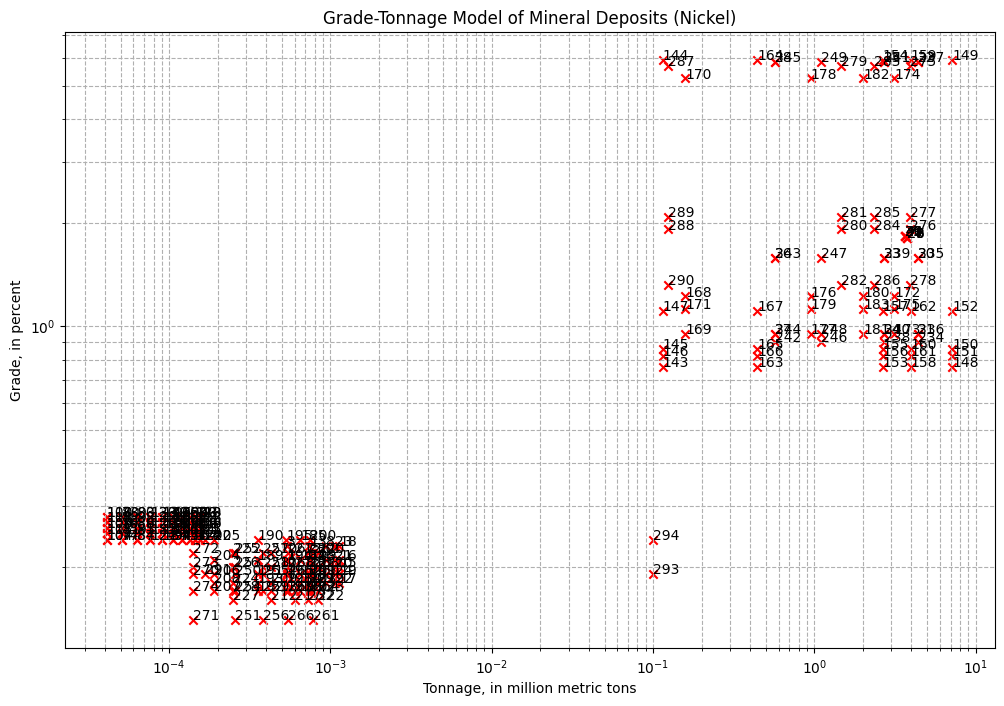

In [65]:
tonnages = mineral_data_df['tonnage'].values
grades = mineral_data_df['grade'].values
names = mineral_data_df.index.values # mineral_data_df['name'].values

# todo: convert tonnage to million metric tons using unit-transformation
tonnages_million_metric_tons = tonnages / 1e6

plt.figure(figsize=(12, 8))
scatter = plt.scatter(tonnages_million_metric_tons, grades, marker='x', color='r')

# loga scale
plt.xscale('log')
plt.yscale('log')

# todo: units should be evaluated and converted
plt.xlabel('Tonnage, in million metric tons')
plt.ylabel('Grade, in percent')
plt.title('Grade-Tonnage Model of Mineral Deposits (Nickel)')

plt.grid(True, which="both", ls="--")
for i, txt in enumerate(names):
    plt.annotate(txt, (tonnages_million_metric_tons[i], grades[i]))
plt.show()

### 6. Coordinate data

In [67]:
from shapely import wkt
from shapely.wkt import loads
from shapely.errors import WKTReadingError

tqdm.pandas()

def safe_wkt_load(wkt_string):
    try:
        return loads(wkt_string)
    except WKTReadingError as e:
        print(f"Error converting WKT: {e}")
        return None

In [68]:
query = '''
SELECT ?site ?loc ?tonnage ?grade
WHERE {
  ?site a :MineralSite .
  ?site :mineral_inventory ?inv .

  ?inv :commodity [ :name "Nickel"@en ] .
  ?inv :category  :Indicated .
  ?inv :ore       [ :ore_value   ?tonnage ] .
  ?inv :grade     [ :grade_value ?grade ] .
  
  ?site:location_info [ :location ?loc ] .
  FILTER(datatype(?loc) = geo:wktLiteral)
}
'''
loc_df = run_minmod_query(query, values=True)
loc_df['loc_wkt'] = loc_df['loc.value'].progress_apply(safe_wkt_load)
loc_df.dropna(inplace=True)
loc_df

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 10439.36it/s]


,site.value,loc.value,tonnage.value,grade.value,loc_wkt
0,https://minmod.isi.edu/resource/site__sudbury-...,POINT (46.49230 -81.06776),40.8,1.27,POINT (46.4923 -81.06776)
1,https://minmod.isi.edu/resource/site__sudbury-...,POINT (46.80500 -80.87806),0.264,0.65,POINT (46.805 -80.87806)
2,https://minmod.isi.edu/resource/site__sudbury-...,POINT (46.42380 -81.38751),9.741,0.63,POINT (46.4238 -81.38751)
3,https://minmod.isi.edu/resource/site__sudbury-...,POINT (46.74104 -81.13276),1.56,0.94,POINT (46.74104 -81.13276)
4,https://minmod.isi.edu/resource/site__ramu__mu...,POINT (-5.57077 145.20393),42.0,0.9,POINT (-5.57077 145.20393)
5,https://minmod.isi.edu/resource/site__sudbury-...,POINT (46.58103 -80.79985),23.25,2.1,POINT (46.58103 -80.79985)
6,https://minmod.isi.edu/resource/site__maturi-i...,POINT (47.8 -91.8),818.3,0.18,POINT (47.8 -91.8)
7,https://minmod.isi.edu/resource/site__sudbury-...,POINT (46.56702 -80.89786),0.56,1.17,POINT (46.56702 -80.89786)
8,https://minmod.isi.edu/resource/site__sudbury-...,POINT (46.77810 -80.87570),6.7,0.72,POINT (46.7781 -80.8757)
9,https://minmod.isi.edu/resource/site__stillwat...,POINT (45.39 -109.9),55.4,0.1,POINT (45.39 -109.9)
